In [1]:
import duckdb
import pyarrow.dataset as ds
import pandas as pd

In [2]:
dataset = ds.dataset("data/status", format="parquet", partitioning="hive")

In [3]:
dataset.count_rows()

382286723

In [4]:
con = duckdb.connect()
con = con.register("status", dataset)

In [5]:
schema_df = con.execute(
    """
    describe status"""
).df()

In [6]:
schema_df

,column_name,column_type,null,key,default,extra
0,is_charging_station,BOOLEAN,YES,NaN,NaN,NaN
1,is_installed,BIGINT,YES,NaN,NaN,NaN
2,is_renting,BIGINT,YES,NaN,NaN,NaN
3,is_returning,BIGINT,YES,NaN,NaN,NaN
4,last_reported,BIGINT,YES,NaN,NaN,NaN
5,num_bikes_available,BIGINT,YES,NaN,NaN,NaN
6,num_bikes_available_types,"STRUCT(ebike BIGINT, mechanical BIGINT)",YES,NaN,NaN,NaN
7,num_bikes_disabled,BIGINT,YES,NaN,NaN,NaN
8,num_docks_available,BIGINT,YES,NaN,NaN,NaN
9,num_docks_disabled,BIGINT,YES,NaN,NaN,NaN


In [7]:
duckdf = con.execute(
    """
    select
        make_timestamp(year, month, day, hour, minute, 0.0) as ts,
        station_id,
        hour,
        minute,
        dayofweek(make_timestamp(year, month, day, hour, minute, 0.0)) as dow,
        num_bikes_available,
        num_bikes_disabled,
        num_docks_available,
        num_docks_disabled,
        minute(lead(make_timestamp(year, month, day, hour, minute, 0.0), 5) over (
            partition by station_id
            order by make_timestamp(year, month, day, hour, minute, 0.0) asc
        ) - make_timestamp(year, month, day, hour, minute, 0.0))  as minutes_bt_check,
        lead(num_bikes_available, 5) over (
            partition by station_id
            order by make_timestamp(year, month, day, hour, minute, 0.0) asc
        ) as bikes_available,
    from
        status
    where
        month > 1 and
        station_id = 3 and
        status = 'IN_SERVICE' and
        year = 2022"""
).df()
duckdf.head()

,ts,station_id,hour,minute,dow,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,minutes_bt_check,bikes_available
0,2022-02-01 00:00:00,3,0,0,2,0,1,19,0,5.0,0.0
1,2022-02-01 00:01:00,3,0,1,2,0,1,19,0,5.0,0.0
2,2022-02-01 00:02:00,3,0,2,2,0,1,19,0,5.0,0.0
3,2022-02-01 00:03:00,3,0,3,2,0,1,19,0,5.0,0.0
4,2022-02-01 00:04:00,3,0,4,2,0,1,19,0,5.0,0.0


In [8]:
len(duckdf)

377083

# Prophet

In [9]:

from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [10]:
duckdf['ds'] = duckdf['ts']
duckdf['y'] = duckdf['num_bikes_available']

duckdf['floor'] = 0
duckdf['cap'] = duckdf['num_docks_available'] + duckdf['num_bikes_available']
# m = Prophet(growth='logistic')
# m.fit(duckdf[duckdf["ds"]< '2022-03-01' ][["ds", "y", "floor", "cap"]])
m = Prophet()
m.fit(duckdf[(duckdf["ds"] >= '2022-05-01') & (duckdf["ds"] < '2022-08-01')][["ds", "y"]])

11:57:13 - cmdstanpy - INFO - Chain [1] start processing
11:59:40 - cmdstanpy - INFO - Chain [1] done processing


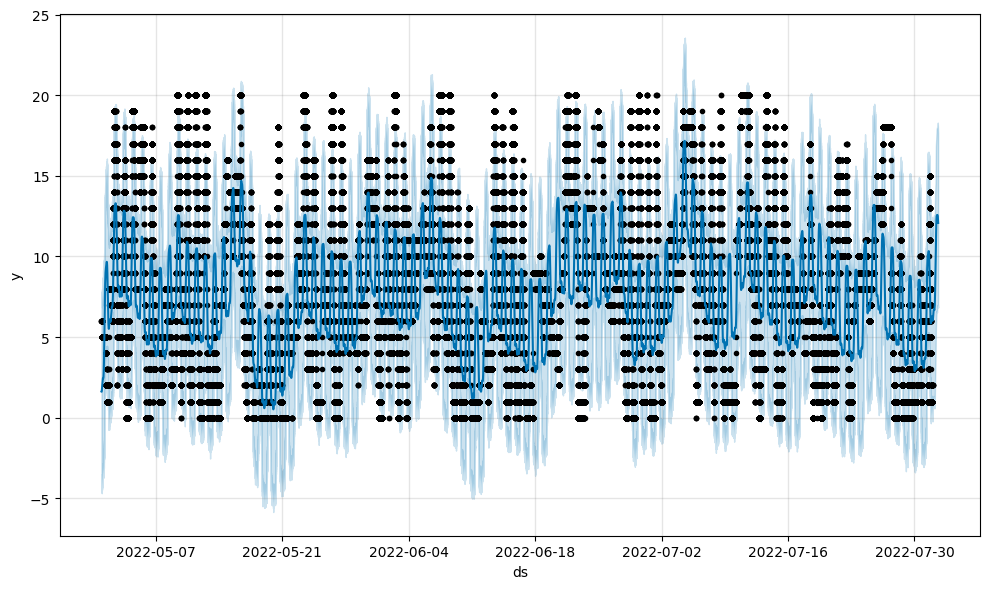

In [11]:
future = m.make_future_dataframe(periods=15, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

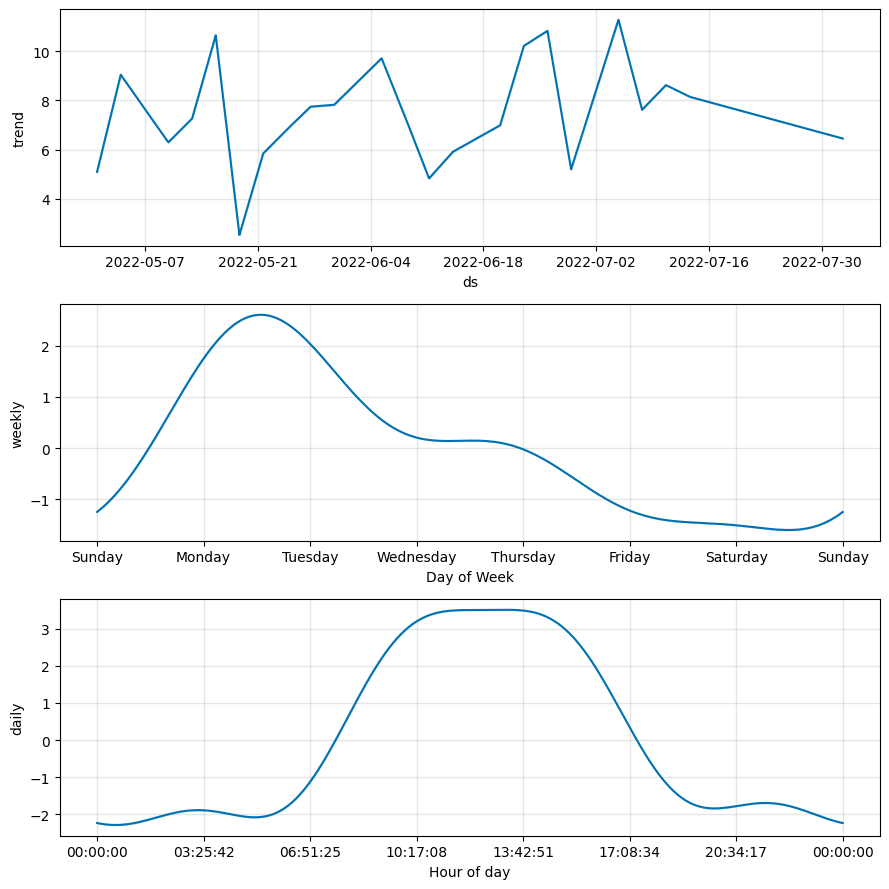

In [12]:
fig = m.plot_components(fcst);

In [13]:
fcst = m.predict(duckdf[(duckdf["ds"] >= '2022-08-01') & (duckdf["ds"] < '2022-09-01')][["ds", "y"]])

In [14]:
fcst["y"] = duckdf[(duckdf["ds"] >= '2022-08-01') & (duckdf["ds"] < '2022-09-01')]["y"].values

In [15]:
fcst["bike_a_pred"] = fcst["yhat"]>0
fcst["bike_a"] = fcst["y"]>0
fcst[["bike_a", "bike_a_pred"]]
len(fcst[fcst["bike_a"] == fcst["bike_a_pred"]]) / len(fcst)

0.854831118183652

In [16]:
len(fcst[(fcst["bike_a"] == fcst["bike_a_pred"]) & (fcst["bike_a"] == False)]) / len(fcst[fcst["bike_a"] == False])

0.0

Es un buen estimador de cuantas bicis va a haber en un momento dado, pero un mal predictor para saber si va a haber bicis o no.

# Random forest a 5 min

In [17]:
train_set = duckdf[(duckdf["ts"] >= '2022-05-01') & (duckdf["ts"] < '2022-08-01')][["num_bikes_available", "hour", "dow"]]

In [18]:
train_set["avail_1_min"] = train_set["num_bikes_available"].shift(1)
train_set = train_set.dropna()

In [19]:
train_set.head()

,num_bikes_available,hour,dow,avail_1_min
112985,6,0,0,6.0
112986,6,0,0,6.0
112987,6,0,0,6.0
112988,6,0,0,6.0
112989,6,0,0,6.0


In [20]:
test_set = duckdf[(duckdf["ts"] >= '2022-08-01') & (duckdf["ts"] < '2022-09-01')][["num_bikes_available", "hour", "dow", "bikes_available"]]


In [21]:
test_set["bike_a_pred"] = test_set["num_bikes_available"]>0
test_set["bike_a"] = test_set["bikes_available"]>0
(len(test_set[test_set["bike_a"] == test_set["bike_a_pred"]]) / len(test_set),
len(test_set[(test_set["bike_a"] == test_set["bike_a_pred"]) & (test_set["bike_a"] == False)]) / len(test_set[test_set["bike_a"] == False]))

(0.9794248828921711, 0.9291338582677166)

Predecir el mismo estado en 5 minutos da un 97.9% de precision, y un 92,9% en los casos q no hay bicicletas.

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix

In [23]:
rf_pipe = make_pipeline(ColumnTransformer([("ohe",  OneHotEncoder(), ["hour", "dow"])], remainder="passthrough"), RandomForestRegressor())


In [24]:
rf_pipe.fit(train_set[["num_bikes_available", "hour", "dow"]], train_set["avail_1_min"])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['hour', 'dow'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [25]:
test_set["num_bikes_available_0"] = test_set["num_bikes_available"]
for i in range(1,6):
    test_set["p"+str(i)] = rf_pipe.predict(test_set[["num_bikes_available", "hour", "dow"]])
    test_set["num_bikes_available"] = test_set["p"+str(i)]
test_set["num_bikes_available"] = test_set["num_bikes_available_0"]
del test_set["num_bikes_available_0"]

In [26]:
test_set["bike_a_pred"] = test_set["p5"]>=1
test_set["bike_a"] = test_set["bikes_available"]>0
test_set[["bike_a", "bike_a_pred"]]
(len(test_set[test_set["bike_a"] == test_set["bike_a_pred"]]) / len(test_set),
len(test_set[(test_set["bike_a"] == test_set["bike_a_pred"]) & (test_set["bike_a"] == False)]) / len(test_set[test_set["bike_a"] == False]))

(0.951610372727884, 0.8923884514435696)

In [27]:
test_set.tail()

,num_bikes_available,hour,dow,bikes_available,bike_a_pred,bike_a,p1,p2,p3,p4,p5
289871,3,23,3,3.0,True,True,3.019783,3.019783,3.019783,3.019783,3.019783
289872,3,23,3,3.0,True,True,3.019783,3.019783,3.019783,3.019783,3.019783
289873,3,23,3,3.0,True,True,3.019783,3.019783,3.019783,3.019783,3.019783
289874,3,23,3,3.0,True,True,3.019783,3.019783,3.019783,3.019783,3.019783
289875,3,23,3,3.0,True,True,3.019783,3.019783,3.019783,3.019783,3.019783


In [28]:
sorted(list(zip(rf_pipe["columntransformer"].get_feature_names_out(), rf_pipe["randomforestregressor"].feature_importances_)),
        key= lambda x: x[1],reverse=True
)[:10]

[('remainder__num_bikes_available', 0.999832149007385),
 ('ohe__dow_4', 2.03979981981516e-05),
 ('ohe__dow_5', 1.5162801778448611e-05),
 ('ohe__dow_3', 1.4317942137022796e-05),
 ('ohe__dow_2', 1.3669147147696345e-05),
 ('ohe__dow_1', 1.2541785510521641e-05),
 ('ohe__dow_0', 1.1530537515543412e-05),
 ('ohe__hour_9', 9.069575335532109e-06),
 ('ohe__hour_16', 7.0062561647068456e-06),
 ('ohe__hour_8', 5.373549119659723e-06)]

Usar un random forest performa peor que el modelo base, y usa como principal feature el numero de bicicletas actuales.

# Usar minutos como feature

El foco del modelo es no enviar a un usuario a buscar una bicicleta cuando no este disponible, osea la tasa de falsos postivos.

Para mejorar la tasa de falsos positivos vamos a usar pesos por clases en las muestras durante el entrenamiento.

In [29]:
dfs_to_concat = []
for i in range(1,16):
    auxdf = con.execute(
        f"""
        select
            make_timestamp(year, month, day, hour, minute, 0.0) as ts,
            station_id,
            hour,
            minute,
            dayofweek(make_timestamp(year, month, day, hour, minute, 0.0)) as dow,
            num_bikes_available,
            num_bikes_disabled,
            num_docks_available,
            num_docks_disabled,
            minute(lead(make_timestamp(year, month, day, hour, minute, 0.0), {i}) over (
                partition by station_id
                order by make_timestamp(year, month, day, hour, minute, 0.0) asc
            ) - make_timestamp(year, month, day, hour, minute, 0.0))  as minutes_bt_check,
            lead(num_bikes_available, {i}) over (
                partition by station_id
                order by make_timestamp(year, month, day, hour, minute, 0.0) asc
            ) as bikes_available,
        from
            status
        where
            (month = 3 or month = 4) and
            station_id = 3 and
            status = 'IN_SERVICE' and
            year = 2022"""
    ).df()
    dfs_to_concat.append(auxdf)
mins_df = pd.concat(dfs_to_concat)
del dfs_to_concat
mins_df["bikes_a"] = mins_df["bikes_available"] > 0
mins_df.head()

,ts,station_id,hour,minute,dow,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,minutes_bt_check,bikes_available,bikes_a
0,2022-03-01 01:23:00,3,1,23,2,1,1,18,0,1.0,1.0,True
1,2022-03-01 01:24:00,3,1,24,2,1,1,18,0,1.0,1.0,True
2,2022-03-01 01:25:00,3,1,25,2,1,1,18,0,14.0,1.0,True
3,2022-03-01 01:39:00,3,1,39,2,1,1,18,0,2.0,1.0,True
4,2022-03-01 01:41:00,3,1,41,2,1,1,18,0,3.0,1.0,True


In [30]:
len(mins_df), len(mins_df[mins_df["bikes_a"] == False])/len(mins_df)

(1251675, 0.2534363952303913)

In [31]:
train_set = mins_df[mins_df["ts"] < '2022-04-9']
val_set = mins_df[(mins_df["ts"] >= '2022-04-9') & (mins_df["ts"] < '2022-04-17')]
test_set = mins_df[mins_df["ts"] >= '2022-04-17']
len(train_set), len(val_set), len(test_set)

(785085, 164235, 302355)

In [32]:
test_set["bikes_a_pred"] = test_set["num_bikes_available"]>0
(len(test_set[test_set["bikes_a"] == test_set["bikes_a_pred"]]) / len(test_set),
len(test_set[(test_set["bikes_a"] == test_set["bikes_a_pred"]) & (test_set["bikes_a"] == False)]) / len(test_set[test_set["bikes_a"] == False]))

/tmp/ipykernel_25649/2623517162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["bikes_a_pred"] = test_set["num_bikes_available"]>0


(0.9650410940781532, 0.9304851085966965)

In [33]:
confusion_matrix(test_set["bikes_a"], test_set["bikes_a_pred"], labels=[True, False])

array([[220240,   5225],
       [  5345,  71545]])

In [34]:
confusion_matrix(test_set["bikes_a"], test_set["bikes_a_pred"], labels=[True, False], normalize="true")

array([[0.97682567, 0.02317433],
       [0.06951489, 0.93048511]])

In [35]:
nn_feat_transf = ColumnTransformer([("ohe",  OneHotEncoder(sparse=False), ["hour", "dow"]),
                                    ("ss",  StandardScaler(),
                                    ["num_bikes_available", "num_bikes_disabled", "num_docks_available", "num_docks_disabled", "minutes_bt_check"])])

In [36]:
train_set_feats = nn_feat_transf.fit_transform(train_set)
val_set_feats = nn_feat_transf.transform(val_set)
test_set_feats = nn_feat_transf.transform(test_set)

In [37]:
from tensorflow import keras

nn_model = keras.Sequential(
    [
        keras.layers.Dense(
            128, activation="relu", input_shape=(train_set_feats.shape[-1],)
        ),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)


2022-11-26 12:02:29.429936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 12:02:29.668698: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-26 12:02:29.702679: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-26 12:02:29.702693: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [38]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

nn_model.compile(
    optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=metrics
)

nn_model.fit(
    train_set_feats,
    train_set["bikes_a"],
    batch_size=2048,
    epochs=30,
    verbose=2,
    validation_data=(val_set_feats, val_set["bikes_a"]),
    class_weight={0: 1, 1: 500},
)


Epoch 1/30
384/384 - 5s - loss: 8.2635 - fn: 2517.0000 - fp: 213324.0000 - tn: 981.0000 - tp: 568263.0000 - precision: 0.7271 - recall: 0.9956 - val_loss: 0.9248 - val_fn: 0.0000e+00 - val_fp: 26025.0000 - val_tn: 0.0000e+00 - val_tp: 138210.0000 - val_precision: 0.8415 - val_recall: 1.0000 - 5s/epoch - 12ms/step
Epoch 2/30
384/384 - 4s - loss: 1.4531 - fn: 0.0000e+00 - fp: 214276.0000 - tn: 29.0000 - tp: 570780.0000 - precision: 0.7271 - recall: 1.0000 - val_loss: 0.7627 - val_fn: 0.0000e+00 - val_fp: 26025.0000 - val_tn: 0.0000e+00 - val_tp: 138210.0000 - val_precision: 0.8415 - val_recall: 1.0000 - 4s/epoch - 9ms/step
Epoch 3/30
384/384 - 5s - loss: 1.0962 - fn: 2.0000 - fp: 179479.0000 - tn: 34826.0000 - tp: 570778.0000 - precision: 0.7608 - recall: 1.0000 - val_loss: 0.6855 - val_fn: 0.0000e+00 - val_fp: 23205.0000 - val_tn: 2820.0000 - val_tp: 138210.0000 - val_precision: 0.8562 - val_recall: 1.0000 - 5s/epoch - 12ms/step
Epoch 4/30
384/384 - 4s - loss: 0.9629 - fn: 4.0000 - fp: 

In [39]:
test_set["bikes_a_pred"] = nn_model.predict(test_set_feats)

9449/9449 [==============================] - 6s 584us/step


/tmp/ipykernel_25649/2808917452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["bikes_a_pred"] = nn_model.predict(test_set_feats)


In [40]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve(test_set["bikes_a"], test_set["bikes_a_pred"])
roc_auc_score(test_set["bikes_a"], test_set["bikes_a_pred"])

0.9731831627967711

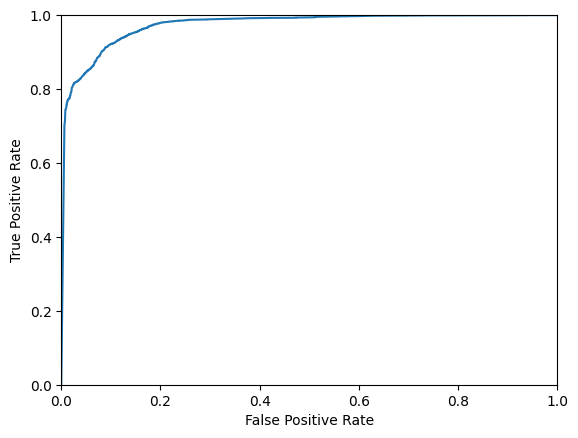

In [41]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()

In [42]:
test_set["bikes_a_pred"] = test_set["bikes_a_pred"]>0.9

/tmp/ipykernel_25649/2066434752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["bikes_a_pred"] = test_set["bikes_a_pred"]>0.9


In [43]:
confusion_matrix(test_set["bikes_a"], test_set["bikes_a_pred"], labels=[True, False])

array([[224496,    969],
       [ 40771,  36119]])

In [44]:
confusion_matrix(test_set["bikes_a"], test_set["bikes_a_pred"], labels=[True, False], normalize="true")

array([[0.99570222, 0.00429778],
       [0.53025101, 0.46974899]])

Con este modelo bajamos a 0.9 la tasa de falsos positivos.

# Create model using a scikit pipeline without dataframes

In [45]:
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline

In [46]:
def create_model(hidden_layer_dim, drop_out_p, meta):
    X_shape_ = meta["X_shape_"]
    nn_model = keras.Sequential([
        keras.layers.Dense(hidden_layer_dim, activation="relu", input_shape=X_shape_[1:]),
        keras.layers.Dense(hidden_layer_dim, activation="relu"),
        keras.layers.Dropout(drop_out_p),
        keras.layers.Dense(hidden_layer_dim, activation="relu"),
        keras.layers.Dropout(drop_out_p),
        keras.layers.Dense(1, activation="sigmoid")
        ]
    )
    return nn_model

keras_cls = KerasClassifier(
    create_model,
    hidden_layer_dim=128,
    drop_out_p=0.25,
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    batch_size=2048,
    epochs=30,
    verbose=0,
    class_weight={0: 1, 1: 500},
)


In [47]:
FEATURES_ORDER = ["hour", "dow", "num_bikes_available", "num_bikes_disabled", "num_docks_available", "num_docks_disabled", "minutes_bt_check"]
keras_pipeline = Pipeline([
    ('preprocess', ColumnTransformer([("ohe",  OneHotEncoder(sparse=False), [0, 1]), ("ss",  StandardScaler(), slice(2,7))])),
    ('keras_cls', keras_cls),
])

In [48]:
X_train = train_set[:10000][FEATURES_ORDER].values
y_train = train_set[:10000]["bikes_a"].values
keras_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(sparse=False),
                                                  [0, 1]),
                                                 ('ss', StandardScaler(),
                                                  slice(2, 7, None))])),
                ('keras_cls',
                 KerasClassifier(batch_size=2048, class_weight={0: 1, 1: 500}, drop_out_p=0.25, epochs=30, hidden_layer_dim=128, loss='binary_crossentropy', model=<function create_model at 0x7f0e6c255bd0>, optimizer=<keras.optimizers.optimizer_experimental.adam.Adam object at 0x7f0e6c217be0>, verbose=0))])

In [49]:
keras_pipeline.predict_proba(test_set[:3][FEATURES_ORDER].values)

array([[0.00276625, 0.99723375],
       [0.00276625, 0.99723375],
       [0.00276625, 0.99723375]], dtype=float32)

### Dump and load model

In [50]:
import joblib

In [51]:
# joblib.dump(keras_pipeline, 'current_model.joblib')
# loaded_model = joblib.load('current_model.joblib')

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
FEATURES_ORDER = ["hour", "dow", "num_bikes_available", "num_bikes_disabled", "num_docks_available", "num_docks_disabled", "minutes_bt_check"]
nn_pipeline = Pipeline([
    ('preprocess', ColumnTransformer([("ohe",  OneHotEncoder(sparse=False), [0, 1]), ("ss",  StandardScaler(), slice(2,7))])),
    ('rf_cls', RandomForestClassifier(n_estimators=200, class_weight={0: 1, 1: 500})),
])

In [54]:
X_train = train_set[:10000][FEATURES_ORDER].values
y_train = train_set[:10000]["bikes_a"].values
nn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(sparse=False),
                                                  [0, 1]),
                                                 ('ss', StandardScaler(),
                                                  slice(2, 7, None))])),
                ('rf_cls',
                 RandomForestClassifier(class_weight={0: 1, 1: 500},
                                        n_estimators=200))])

In [55]:
joblib.dump(nn_pipeline, 'current_model.joblib')
loaded_model = joblib.load('current_model.joblib')

In [56]:
loaded_model.predict_proba(test_set[:3][FEATURES_ORDER].values)

array([[0.09500766, 0.90499234],
       [0.09500766, 0.90499234],
       [0.09500766, 0.90499234]])